# Wildfire Detection

### Importing Libraries

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

2024-05-28 09:41:29.892467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 09:41:29.892568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 09:41:30.004148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Preparing Data

In [2]:
train_dir = '/kaggle/input/wildfire-detection-image-data/forest_fire/Training and Validation'
test_dir = '/kaggle/input/wildfire-detection-image-data/forest_fire/Testing'

In [3]:
# ImageDataGenerator for original images (no augmentation)
original_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for augmented images
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
batch_size = 32
img_height, img_width = 224, 224  # ResNet50V2 expects 224x224 images

In [5]:
# Original images generator
original_train_generator = original_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Augmented images generator
augmented_train_generator = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

Found 1832 images belonging to 2 classes.
Found 1832 images belonging to 2 classes.


In [6]:
# Function to create a tf.data.Dataset from ImageDataGenerator
def create_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, img_height, img_width, 3], [None])
    )
    dataset = dataset.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

original_dataset = create_dataset(original_train_generator)
augmented_dataset = create_dataset(augmented_train_generator)

combined_train_dataset = original_dataset.concatenate(augmented_dataset)

In [7]:
# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_dataset = create_dataset(test_generator)

Found 68 images belonging to 2 classes.


### Data Viz

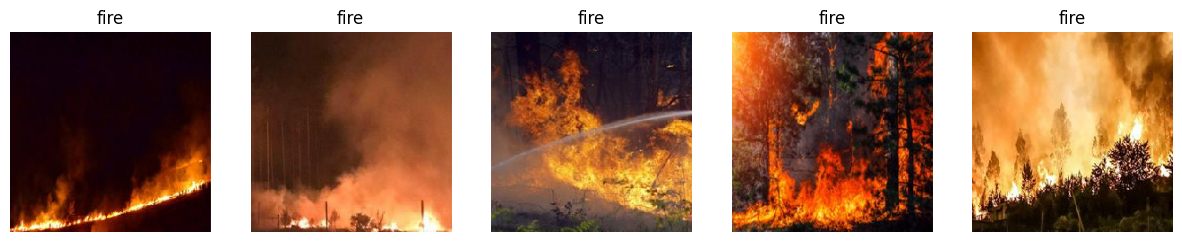

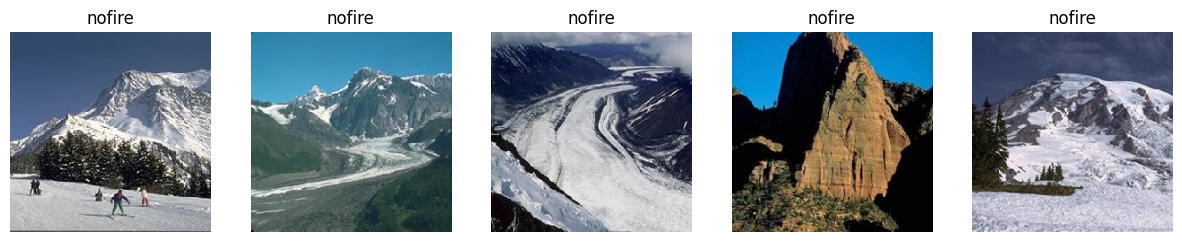

In [8]:
def plot_images(directory, category, num_images):
    category_dir = os.path.join(directory, category)
    images = os.listdir(category_dir)[:num_images]
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_dir, img_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Plotting 5 fire and 5 nofire images
plot_images(train_dir, 'fire', 5)
plot_images(train_dir, 'nofire', 5)


### Model Training

In [9]:
# Load the pre-trained ResNet50V2 model
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False

# Create the model
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,098,817 (91.93 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 23,569,408 (89.91 MB)

In [10]:
# Calculate steps_per_epoch and validation_steps
train_samples = original_train_generator.samples + augmented_train_generator.samples
test_samples = test_generator.samples

steps_per_epoch = train_samples // batch_size
validation_steps = test_samples // batch_size

In [11]:
# Initial training
epochs = 10
history = model.fit(
    combined_train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps
)

Epoch 1/10
  4/114 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5423 - loss: 0.8900

I0000 00:00:1716889326.055505      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


114/114 ━━━━━━━━━━━━━━━━━━━━ 35s 150ms/step - accuracy: 0.9151 - loss: 0.2007 - val_accuracy: 0.9688 - val_loss: 0.0571
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.9836 - loss: 0.0503 - val_accuracy: 0.9688 - val_loss: 0.0627
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.9866 - loss: 0.0389 - val_accuracy: 0.9844 - val_loss: 0.0485
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.9907 - loss: 0.0263 - val_accuracy: 0.9844 - val_loss: 0.0436
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.9931 - loss: 0.0199 - val_accuracy: 0.9844 - val_loss: 0.0225
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.9940 - loss: 0.0159 - val_accuracy: 0.9844 - val_loss: 0.0220
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.9900 - loss: 0.0264 - val_accuracy: 1.0000 - val_loss: 0.0137
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.9925 - loss: 0.0234 - val_accuracy: 0.9

### Model Evaluation

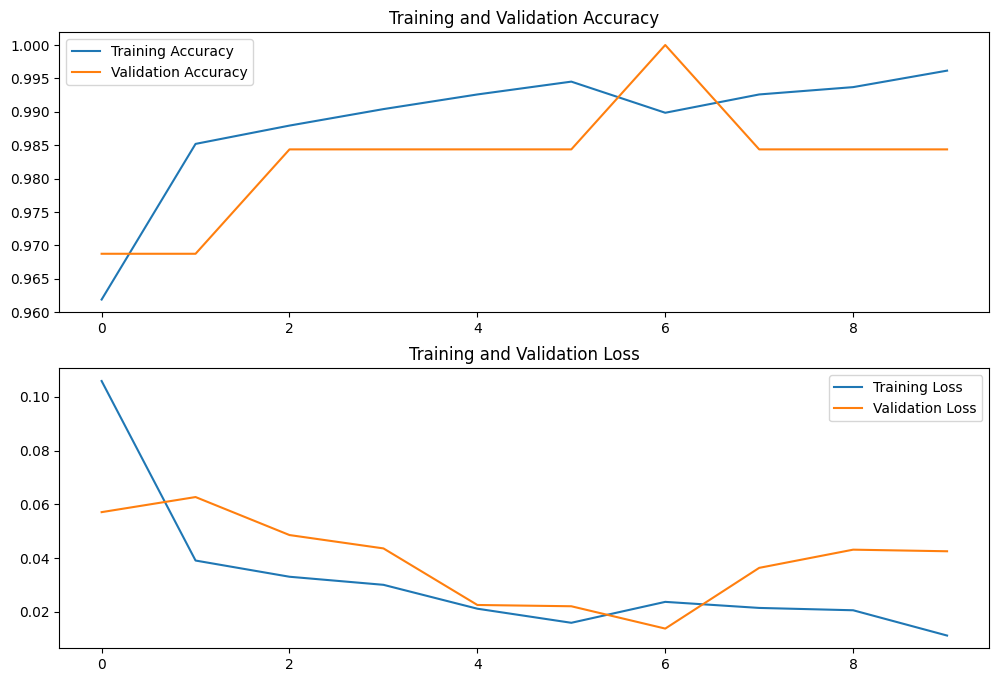

In [12]:
# Function to plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))
    
    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


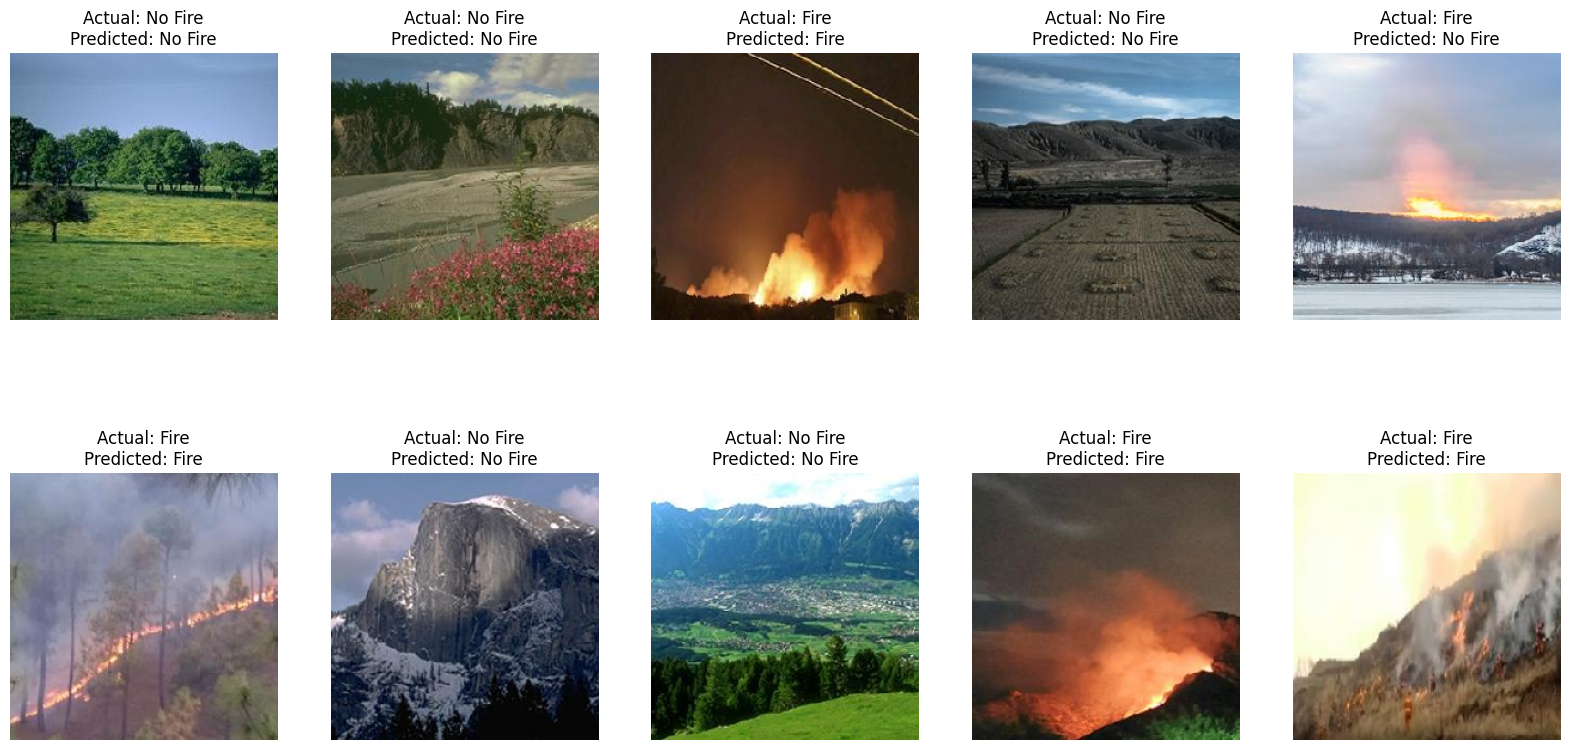

In [13]:
while True:
    try:
        test_images, test_labels = next(test_generator)
        predictions = model.predict(test_images)

        fire_indices = np.where(test_labels == 1)[0]
        nofire_indices = np.where(test_labels == 0)[0]

        random_fire_indices = np.random.choice(fire_indices, 5, replace=False)
        random_nofire_indices = np.random.choice(nofire_indices, 5, replace=False)

        random_indices = np.concatenate((random_fire_indices, random_nofire_indices))
        np.random.shuffle(random_indices)

        # Plot the images with predictions
        plt.figure(figsize=(20, 10))
        for i, idx in enumerate(random_indices):
            plt.subplot(2, 5, i+1)
            plt.imshow(test_images[idx])
            plt.title(f"Actual: {'No Fire' if test_labels[idx] == 1 else 'Fire'}\nPredicted: {'No Fire' if predictions[idx] >= 0.5 else 'Fire'}")
            plt.axis('off')

        plt.show()
        break
        
    except ValueError:
        pass

> **NOTE:** Due to alphabetical order "Fire" is labelled as "0" and "No Fire" is labelled as "1"

In [14]:
# Save the trained model
model.save('wildfire_detection_model.keras')